 # KBC Direct Market Optimization

### Below source code represents classifying customers having high propensity to buy Mutual Funds

In [323]:
#############################################################################################
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xlrd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Imputer
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegressionCV

In [324]:
#############################################################################################
# Import excel file from location
file_location = ('Task_Data_Scientist_Dataset.xlsx')
workbook = xlrd.open_workbook(file_location)
print("the number of worksheets are",workbook.nsheets)

the number of worksheets are 5


In [325]:
#############################################################################################
# Load sequentially the spread sheets into subsequent dataframe
spread_sheet = pd.ExcelFile(file_location)
socail_demographic = spread_sheet.parse('Soc_Dem')
products_balance = spread_sheet.parse('Products_ActBalance')
inflow_outflow = spread_sheet.parse('Inflow_Outflow')
sales_revenue = spread_sheet.parse('Sales_Revenues')

In [326]:
#############################################################################################
# Merge the sheets to one major sheet in order to implement the learning model
merge_first_second = pd.merge(socail_demographic, products_balance, how='left', left_on='Client', right_on='Client') 
merge_second_third = pd.merge(inflow_outflow, sales_revenue, how='left', left_on='Client', right_on='Client')
result_merged = pd.merge(merge_first_second, merge_second_third, how='left', left_on='Client', right_on='Client')
result_merged = result_merged.set_index('Client')

na_entries = {'Count_MF': 79, 'Count_CL':5,
              'Count_OVD':2,'Count_CC':2,
              'ActBal_SA':0,'ActBal_MF':0,
              'ActBal_OVD':0, 'Count_SA': 6,
              'ActBal_CC':0,'ActBal_CL':0 }
result_merged = result_merged.fillna(value=na_entries, inplace=False)
result_merged =result_merged .dropna(axis=0, how='any')

In [327]:
#############################################################################################
# Implement LabelEncoder class to convert categorical variables to numerical values
number=LabelEncoder()
result_merged ['Sex']=number.fit_transform(result_merged ['Sex'].astype('str'))

# Assign a variable used for prediction by removing Sale_MF, the target variable
prediction_features = result_merged.drop('Sale_MF', axis=1)

# Assign explanatroy and target variables
# Input and output Features
feature_cols = prediction_features
target_cols = result_merged['Sale_MF']  # Sale_MF column is the target/label
X = feature_cols  # feature values for all data points
y= target_cols  # corresponding targets/labels


In [328]:
#############################################################################################
# Handling missing variables by using Imputer Class
imputer = Imputer(missing_values = 'NaN' , strategy = 'mean', axis = 0)
imputer = imputer.fit(X)
X= imputer.transform(X)

In [329]:
#############################################################################################
#Cross validation on the given data to split the training and test set
X_train,X_test,y_train,y_test = cross_validation.train_test_split(X, y, train_size=650)

In [330]:
#############################################################################################
# Training a model - Method to train a given model
import time

def train_classifier(clf, X_train, y_train):
    print ("Training {}...".format(clf.__class__.__name__))
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    trainingtime=end-start
    print ("Done!\nTraining time (secs): {:.3f}".format(trainingtime))
    return trainingtime


In [331]:
#############################################################################################
# Fitting Logistic Regression to the Training set
clf = LogisticRegressionCV()
LR_trainingtime = train_classifier(clf, X_train, y_train)  # Using entire training set here
print(LR_trainingtime)

Training LogisticRegressionCV...
Done!
Training time (secs): 1.576
1.5760900974273682


In [332]:
#############################################################################################
# Predicting the performance metrics on training set and compute F1 score for Logistic Regression
from sklearn.metrics import f1_score

def predict_labels(clf, features, target):
     print ("Predicting labels using {}...".format(clf.__class__.__name__))
     start = time.time()
     y_pred = clf.predict(features)
     end = time.time()
     print ("Done!\nPrediction time (secs): {:.3f}".format(end - start))
     return f1_score(target, y_pred, pos_label=1)

train_f1_score = predict_labels(clf, X_train, y_train)
print ("F1 score for training set in Logistic Regression: {}".format(train_f1_score))

# Predict on test data
print ("F1 score for test set in Logistic Regression: {}".format(predict_labels(clf, X_test, y_test)))

Predicting labels using LogisticRegressionCV...
Done!
Prediction time (secs): 0.001
F1 score for training set in Logistic Regression: 0.32298136645962733
Predicting labels using LogisticRegressionCV...
Done!
Prediction time (secs): 0.057
F1 score for test set in Logistic Regression: 0.29333333333333333


In [333]:
#############################################################################################
# Implementing Decision Tree Classifier since F1 score for Logistic Regression is comparitively less
from sklearn.tree import DecisionTreeClassifier
decision_clf = DecisionTreeClassifier()

# Fitting the model to training data
DTC_trainingtime = train_classifier(decision_clf, X_train, y_train)

train_f1_score = predict_labels(decision_clf, X_train, y_train)

# Predict on test data
print ("F1 score for training set with Decision Tree Classifier: {}".format(train_f1_score))

# Predict on test data
print ("F1 score for test set with Decision Tree Classifier: {}".format(predict_labels(decision_clf, X_test, y_test)))

Training DecisionTreeClassifier...
Done!
Training time (secs): 0.119
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.001
F1 score for training set with Decision Tree Classifier: 1.0
Predicting labels using DecisionTreeClassifier...
Done!
Prediction time (secs): 0.001
F1 score for test set with Decision Tree Classifier: 1.0


In [334]:
#############################################################################################
# Evaluating Confusion Matrix - 
y_pred = decision_clf.predict(X_test)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[238   0]
 [  0  61]]


In [335]:
#############################################################################################
# Predicting the Test set results using Decision Tree Classifier
y_pred = decision_clf.predict(prediction_features)

In [336]:
#############################################################################################
# Adding the credit card sale classified value to last column
prediction_features['Predicted_Sale_MF'] = y_pred
prediction_classified_features=prediction_features.loc[prediction_features['Predicted_Sale_MF'] == 1]
prediction_classified_target = prediction_classified_features['Revenue_MF']
prediction_classified_features.head()

Sex  Age  Tenure  Count_CA  Count_SA  Count_MF  Count_OVD  Count_CC  \
Client                                                                        
1473      1   54      34         1       1.0      79.0        2.0       1.0   
36        0   49     263         1       1.0       2.0        2.0       2.0   
390       1   50      67         1       1.0      79.0        2.0       2.0   
416       0   44      95         1       6.0      79.0        2.0       2.0   
883       0   34      67         1       6.0      79.0        2.0       2.0   

        Count_CL   ActBal_CA        ...          TransactionsDeb_CA  \
Client                              ...                               
1473         1.0   29.024286        ...                        38.0   
36           5.0   60.997857        ...                         0.0   
390          5.0  442.346071        ...                        38.0   
416          5.0  906.526071        ...                        25.0   
883          5.0  236.217857        ...                         7.0   

        TransactionsDebCash_Card  TransactionsDebCashless_Card  \
Client                                                           
1473                         1.0                          26.0   
36                           0.0                           0.0   
390                          2.0                          29.0   
416                          4.0                          21.0   
883                          2.0                           0.0   

        TransactionsDeb_PaymentOrder  Sale_CC  Sale_CL  Revenue_MF  \
Client                                                               
1473                            11.0      0.0      0.0    4.929643   
36                               0.0      0.0      0.0    0.238036   
390                              6.0      0.0      0.0    1.379821   
416                              0.0      0.0      0.0   10.363036   
883                              4.0      0.0      0.0    2.231964   

        Revenue_CC  Revenue_CL  Predicted_Sale_MF  
Client                                             
1473           0.0         0.0                1.0  
36             0.0         0.0                1.0  
390            0.0         0.0                1.0  
416            0.0         0.0                1.0  
883            0.0         0.0                1.0  

[5 rows x 35 columns]

# Below code describes the regression part of the problem
# Provides the calculation of revenue based on consumer loan users

In [337]:
#############################################################################################
# Implement LabelEncoder class to convert categorical variables to numerical
from sklearn.preprocessing import LabelEncoder
number=LabelEncoder()
result_merged ['Sex']=number.fit_transform(result_merged ['Sex'].astype('str'))

In [338]:
#############################################################################################
#Removing the irrevelant features from exploratory variables because of multi-collinearity
prediction_regression_features = result_merged
# Data set for CL customers
columns=['Sale_MF', 'Sale_CL','Sale_CC','Revenue_MF','Revenue_CC', 'Revenue_CL']
prediction_regression_features=prediction_regression_features.drop(columns, axis=1)

columns=['Sale_CL','Sale_CC','Revenue_MF','Revenue_CC','Revenue_CL','Predicted_Sale_MF']
prediction_classified_features=prediction_classified_features.drop(columns, axis=1)

# Assign explanatroy and target variables
# Input and output Features
feature_cols = prediction_regression_features
target_cols = result_merged['Revenue_MF']  # Revenue_MF column is the target/label
X_reg = feature_cols  # feature values for all data points
y_reg= target_cols  # corresponding targets/labels

In [339]:
#############################################################################################
# Handling missing variables
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values = 'NaN' , strategy = 'mean', axis = 0)
imputer = imputer.fit(X_reg)
X_reg= imputer.transform(X_reg)

In [340]:
#############################################################################################
#Cross validation on the given training data set to split training and test set
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
X_reg_train,X_reg_test,y_reg_train,y_reg_test = cross_validation.train_test_split(X_reg, y_reg, train_size=600)

In [341]:
###############################################################################
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()

In [342]:
###############################################################################
# Fit a model 
from sklearn.metrics import make_scorer
from sklearn import grid_search
from sklearn.metrics import mean_squared_error
def fit_model(X1, y1):

    # Setting up the parameters we wish to tune
    parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

    # Making an appropriate scoring function
    scoring_function = make_scorer(mean_squared_error,greater_is_better=False)

    # Making the GridSearchCV object
    reg = grid_search.GridSearchCV(regressor, parameters,scoring=scoring_function)

    # Fitting the the learner to the data to obtain the optimal model with tuned parameters
    reg.fit(X1, y1)

    # Returning the optimal model
    return reg

try:
    regression_Mutual_Fund = fit_model(X_reg_train, y_reg_train)
    print ("Successfully fit a model!")
except:
    print ("Something went wrong with fitting a model.")

Successfully fit a model!


In [343]:
# Lasso
from sklearn.linear_model import Lasso

alpha = 0.1
lasso = Lasso(alpha=alpha)

y_pred_lasso = lasso.fit(X_reg_train, y_reg_train).predict(X_reg_test)
r2_score_lasso = r2_score(y_reg_test, y_pred_lasso)
print(lasso)
print("r^2 on test data : %f" % r2_score_lasso)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
r^2 on test data : -0.775760


In [344]:
# #############################################################################
# ElasticNet
from sklearn.linear_model import ElasticNet

enet = ElasticNet(alpha=alpha, l1_ratio=0.7)

y_pred_enet = enet.fit(X_reg_train, y_reg_train).predict(X_reg_test)
r2_score_enet = r2_score(y_reg_test, y_pred_enet)
print(enet)
print("r^2 on test data : %f" % r2_score_enet)

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.7,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)
r^2 on test data : -0.776921


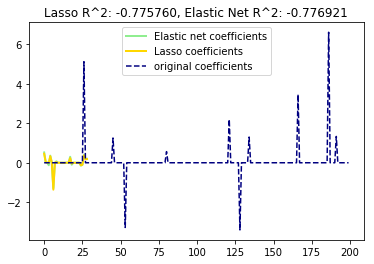

In [345]:
plt.plot(enet.coef_, color='lightgreen', linewidth=2,
         label='Elastic net coefficients')
plt.plot(lasso.coef_, color='gold', linewidth=2,
         label='Lasso coefficients')
plt.plot(coef, '--', color='navy', label='original coefficients')
plt.legend(loc='best')
plt.title("Lasso R^2: %f, Elastic Net R^2: %f"
          % (r2_score_lasso, r2_score_enet))
plt.show()

In [346]:
#regression_Mutual_Fund = fit_model(prediction_classified_features, prediction_classified_target)
print ("Final model optimal parameters:", regression_Mutual_Fund.best_params_)
revenues_MF_predicted = regression_Mutual_Fund.predict(prediction_classified_features)
prediction_classified_features['Predicted_MF_Revenue'] = revenues_MF_predicted

Final model optimal parameters: {'copy_X': True, 'fit_intercept': True, 'normalize': False}


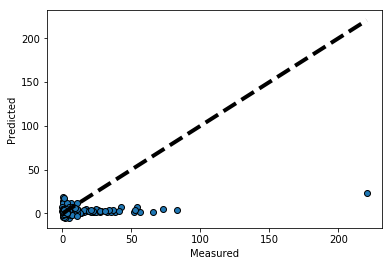

In [347]:
fig, ax = plt.subplots()
ax.scatter(prediction_classified_target, revenues_MF_predicted, edgecolors=(0, 0, 0))
ax.plot([prediction_classified_target.min(), prediction_classified_target.max()], [prediction_classified_target.min(), prediction_classified_target.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [348]:
prediction_classified_features.to_csv('MF_Customers.csv')

In [349]:
pwd

'C:\\Users\\DiyaMol\\KBC-Group'